In [1]:
import os
import cv2
import numpy as np
from time import time
import pymatreader as pymat
from termcolor import colored
import matplotlib.pyplot as plt
from pysptools import material_count, eea, abundance_maps, distance, noise

In [2]:
path_str = os.getcwd()
data_file_name_str = 'Majazi.mat'
Endmembers_name_str = 'Endmember-Majazi.mat'
path_full_data = os.path.join(path_str, data_file_name_str)
path_full_endmembers = os.path.join(path_str, Endmembers_name_str)

In [3]:
data = pymat.read_mat(path_full_data)
End_data = pymat.read_mat(path_full_endmembers)

y = data['Y']
y = y.T
y = y.astype(np.float64)

U = End_data['M']
U = U.T
U = U.astype(np.float64)

X = End_data['A']
X = X.T
X = X.astype(np.float64)

nrows, ncols, nbands, n_select_bands = data['nRow'], data['nCol'], data['nBand'], len(data['SlectBands'])

In [4]:
print(f'\nShape of y(Data): {colored(y.shape, "blue")}\n')
print(f'Shape of U(Endmembers): {colored(U.shape, "blue")}\n')
print(f'Shape of X(Abundance): {colored(X.shape, "blue")}\n')


Shape of y(Data): (94249, 162)

Shape of U(Endmembers): (6, 162)

Shape of X(Abundance): (94249, 6)



$\newline$
$\newline$
- <a name=''>$\bf{\text{Visualization}}$</a>
$\newline$
$\newline$

In [5]:
d = y.reshape((nrows, ncols, n_select_bands))
data_plot = (d[:, :, [3, 10, 30]]).astype(np.uint8)

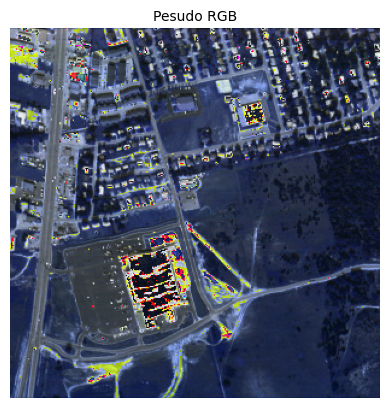

In [6]:
plt.figure(1)
plt.imshow(data_plot), plt.axis('off'), plt.title('Pesudo RGB', fontsize=10)
plt.show()

$\newline$
$\newline$
- <a name=''>$\bf{\text{Standard Scaling}}$</a>
$\newline$
$\newline$

In [7]:
def standard_normalization(data_2d: np.ndarray) -> np.ndarray:
    
    data = data_2d.copy()
    mean_value = data.mean()
    std_value = data.std()
    new_data = (data - mean_value) / (std_value)
    return new_data

In [8]:
normal_y = standard_normalization(y)

$\newline$
$\newline$
- <a name=''>$\bf{\text{FCLSU}}$</a>
$\newline$
$\newline$

In [9]:
tic = time()
X_hat = abundance_maps.amaps.FCLS(M=normal_y, U=U)
toc = time()
run_time = toc - tic
X_hat = X.astype(np.float64)

print(f'\nShape of the {colored("Abundance Matrix(X)", "blue")} for {colored("FCLS", "blue")} Method: \
{X_hat.shape}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_hat.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for this method: {run_time: 0.3f}(s)\n')


Shape of the Abundance Matrix(X) for FCLS Method: (94249, 6)

 ... and its Data Type: float64


Run time for this method:  79.627(s)



$\newline$
$\newline$
- <a name=''>$\bf{\text{SUNSAL}}$</a>
$\newline$
$\newline$

In [11]:
import sunsal

In [12]:
U3, y3 = U.reshape((U.shape[1], U.shape[0])), normal_y.reshape((normal_y.shape[1], normal_y.shape[0]))

In [13]:
tic = time()
X_sunsal, _, _, _ = sunsal.sunsal(M=U3, y=y3, positivity=True, addone=True)
toc = time()
sunsal_run_time = toc - tic
X_sunsal = X_sunsal.reshape((X_sunsal.shape[1], X_sunsal.shape[0]))
print(f'\nShape of {colored("Abundance Matrix", "blue")}: {colored(X_sunsal.shape, "blue")}\n')
print(f' ... and its {colored("Data Type", "blue")}: {colored(X_sunsal.dtype, "blue")}\n')
print(f'\n{colored("Run time", "red")} for {colored("SUNSAL", "blue")} Method: \
{sunsal_run_time: 0.3f}(s)\n')


Shape of Abundance Matrix: (94249, 6)

 ... and its Data Type: float64


Run time for SUNSAL Method:  0.950(s)



$\newline$
$\newline$
- <a name=''>$\bf{\text{RMSE}}$</a>
$\newline$
$\newline$

$\newline$
$\newline$
- - <a name=''>${\text{For FCLSU}}$</a>
$\newline$
$\newline$

In [14]:
rmse_fclsu = np.sqrt(np.sum((X_hat - X) ** 2)/(X_hat.shape[0]*X_hat.shape[1]))
rmse_fclsu

0.0

$\newline$
$\newline$
- - <a name=''>${\text{For SUNSAL}}$</a>
$\newline$
$\newline$

In [15]:
rmse_sunsal = np.sqrt((np.sum((X_sunsal - X) ** 2))/(X_sunsal.shape[0]*X_sunsal.shape[1]))
rmse_sunsal

0.3696821994998465

$\newline$
$\newline$
- <a name=''>$\bf{\text{Plot}}$</a>
$\newline$
$\newline$

In [16]:
X_plot_fclsu = X_hat[:10000, 1]
X_plot_sunsal = X_sunsal[:10000, 1]
X_plot_true = X[:10000, 1]

X_plot_fclsu = X_plot_fclsu.reshape((100, 100))
X_plot_sunsal = X_plot_sunsal.reshape((100, 100))
X_plot_true = X_plot_true.reshape((100, 100))

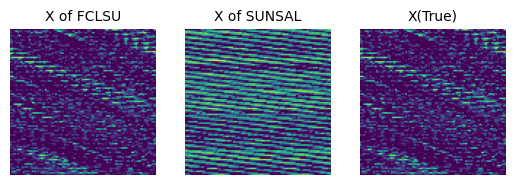

In [21]:
plt.figure(1)
plt.subplot(1, 3, 1), plt.imshow(X_plot_fclsu), plt.axis('off'), plt.title('X of FCLSU', fontsize=10)
plt.subplot(1, 3, 2), plt.imshow(X_plot_sunsal), plt.axis('off'), plt.title('X of SUNSAL', fontsize=10)
plt.subplot(1, 3, 3), plt.imshow(X_plot_true), plt.axis('off'), plt.title('X(True)', fontsize=10)
plt.show()

$\newline$
$\newline$
- <a name=''>$\bf{\text{Creating Noisy Data}}$</a>
$\newline$
$\newline$

In [59]:
def synthetic_noisy_data_generator(data_2d: np.ndarray, SNR_db: float=0, mode: str='gaussian') -> \
(np.ndarray, np.ndarray):
    
    data = data_2d.copy()
    m, n = data.shape
    
    mu, std = 0, 1
    if mode == 'gaussian':
        N = np.random.normal(mu, std, size=(m, n))
    elif mode == 'poisson':
        N = np.random.poisson(lam=1, size=(m, n))
    SNR = 10 ** (SNR_db / 10)
    
    E_x2 = (data ** 2).mean()
    A_coeff = (SNR / E_x2) ** (0.5)
    noisy_data = data + ((1/A_coeff) * N)
    return noisy_data, N

In [56]:
synthetic_data, N = synthetic_noisy_data_generator(normal_y, SNR_db=10)

In [51]:
RN = np.identity(y.shape[1])

$\newline$
$\newline$
- <a name=''>$\bf{\text{q by HySime}}$</a>
$\newline$
$\newline$

In [58]:
q = (material_count.vd.hysime(y=synthetic_data, n=N, Rn=RN))[0]
print(f'q: {q}')

q: 3


$\newline$
$\newline$
<a name=''>$\large{\bf{\text{References}}}$</a>
$\newline$
$\newline$
- <a name=''>[$\underline{\bf{\text{PySpTool}}}$](https://pysptools.sourceforge.io/)</a>
$\newline$
$\newline$